# CPSC 477/577 Spring 2022, HW4 Part 2: Transformer from scratch for machine translation

Due: April 27th, 11:59pm

*TF: Malcolm Sailor*

## Please write your name and NetID below

Name: Qiuyu (Olina) Zhu 

NetID: qz258

In [209]:
!pip install torchdata 



In this notebook, we will implement a transformer model for machine translation.

Transformers were introduced in the paper ["Attention is all you need" (Vaswani et al. 2017)](https://arxiv.org/abs/1706.03762). As the paper title suggests, the key idea that makes transformers work is *attention*. If you want to review attention and transformers, some useful resources include

- the [original paper](https://arxiv.org/abs/1706.03762)
- chapters 9 and 10 of Jurafsky & Martin
- the blog posts [Visualizing A Neural Machine Translation Model](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) and [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/). (The first of these doesn't cover transformers but is useful for understanding attention.)
- Youtube videos such as [this one](https://youtu.be/OyFJWRnt_AY) or [this one](https://youtu.be/iDulhoQ2pro).

The architecture we are going to implement is illustrated in the following figure, taken from the Vaswani et al. paper.

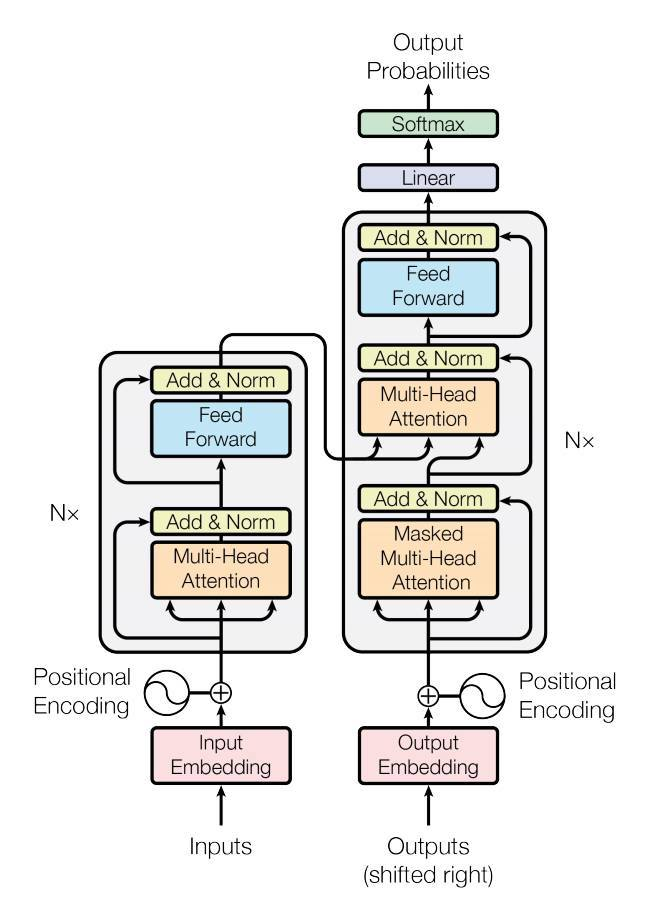

## 2.1 Data pre-processing

The data pre-processing is mostly the same as in Part 1. You just need to make a few small changes which are explained as necessary below.

In [210]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch version is: ", torch.__version__)
print("You are using: ", DEVICE)

Pytorch version is:  1.11.0+cu113
You are using:  cuda


In [211]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

from torchtext.datasets import Multi30k

from typing import Tuple, List

import random
import math
import os
import time

# We'll set the random seeds for deterministic results.
SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

class Placeholder:
    @property
    def DO(self):
        raise NotImplementedError("You haven't yet implemented this part of the assignment yet")

TO = Placeholder()

In [212]:
%%capture
! python -m spacy download en
! python -m spacy download de
from torchtext.data.utils import get_tokenizer
de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

In [213]:
train_data, valid_data, test_data = Multi30k()
from torchtext.vocab import build_vocab_from_iterator

de_generator = (de_tokenizer(pair[0].strip().lower()) for pair in Multi30k(split="train"))
specials = ["<unk>", "<pad>", "<bos>", "<eos>"]
de_vocab = build_vocab_from_iterator(de_generator, specials=specials, min_freq=2)
en_generator = (en_tokenizer(pair[1].strip().lower()) for pair in Multi30k(split="train"))
en_vocab = build_vocab_from_iterator(en_generator, specials=specials, min_freq=2)

for vocab in (de_vocab, en_vocab):
    vocab.set_default_index(vocab["<unk>"])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


You can copy your `data_process()` function from part 1. The only change you need to make is that **we are no longer reversing the source sentence**.

In [214]:
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

def data_process(raw_dataset) -> List[Tuple[Tensor, Tensor]]:
    # STUDENT 
    ret = []
    for pair in raw_dataset: 
      # lower case and strip both German and English tokens in each sentence pair 
      d_tokens = de_tokenizer(pair[0].strip().lower()) 
      e_tokens = de_tokenizer(pair[1].strip().lower()) 

      # add <bos> and <eos> tokens to both German and English sentences 
      d_tokens.insert(0, '<bos>')
      d_tokens.append('<eos>')
      e_tokens.insert(0, '<bos>')
      e_tokens.append('<eos>') 

      # get encoded tensor tuple from vocabs  
      d_tens = torch.tensor([de_vocab[token] for token in d_tokens], dtype=torch.long)
      e_tens = torch.tensor([en_vocab[token] for token in e_tokens], dtype=torch.long)
      tup = (d_tens, e_tens)

      # add tensor tuple to list 
      ret.append(tup) 

    return ret 

train_data, valid_data, test_data = Multi30k()
train_data_processed = data_process(train_data)
valid_data_processed = data_process(valid_data)
test_data_processed = data_process(test_data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Decode the first example. Does it look right? The German should not be reversed.

In [215]:
# Make sure German isn't reversed
de_itos = de_vocab.get_itos()
en_itos = en_vocab.get_itos()
de_encoded, en_encoded = train_data_processed[0]
print(" ".join([de_itos[item] for item in de_encoded]))
print(" ".join([en_itos[item] for item in en_encoded]))

<bos> zwei junge weiße männer sind im freien in der nähe vieler büsche . <eos>
<bos> two young , white males are outside near many bushes . <eos>


You can copy your `collate_fn()` from Part 1. But you need to make the following changes:

1. We no longer need the sentence lengths of the source sentences (because we will not be calling `pack_padded_sequences()` below).
2. Unlike the model in part 1, the model we will implement below expects to have batch as the first dimension. So you may need to use the `batch_first` argument of `pad_sequence()`.

In [216]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']

def collate_fn(data_batch) -> Tuple[Tensor, Tensor]:
    # STUDENT 
    # initialize lists to be added to returned tuple 
    de_batch = [] 
    en_batch = [] 
    for pair in data_batch: 
      de = pair[0]
      en = pair[1] 
      # add indices/lengths to corresponding batches/list
      # de_tens = torch.cat([torch.tensor([BOS_IDX]), de, torch.tensor([EOS_IDX])], 0)
      # en_tens = torch.cat([torch.tensor([BOS_IDX]), en, torch.tensor([EOS_IDX])], 0)
      de_batch.append(de)
      en_batch.append(en)
    # pad sequences 
    # send to GPU 
    de_batch = torch.tensor(pad_sequence(de_batch, padding_value=PAD_IDX, batch_first=True)).to(DEVICE) 
    en_batch = torch.tensor(pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=True)).to(DEVICE) 
    ret = (de_batch, en_batch) 

    return ret 

train_dl = DataLoader(
    train_data_processed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)
valid_dl = DataLoader(
    valid_data_processed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)
test_dl = DataLoader(
    test_data_processed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

# 2.2 Transformer implementation

Unlike an RNN, a transformer processes its entire input all at once, in parallel. Therefore for the model to make use of the *order* of the words in a sentence (e.g., to distinguish "man bites dog" from "dog bites man"), we need to provide it with some information about the position of the sequence. There are a number of different strategies for doing this. Vaswani et al. 2017 used fixed positional encodings based on sinusoidal waveforms. We have provided an implementation below.

In [217]:
class PositionalEncoding(nn.Module):
    def __init__(
        self,
        d_model: int,
        max_len: int = 512,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.full((max_len, d_model), -100.0)
        pos = torch.arange(max_len).unsqueeze(1)
        indxs = torch.arange(d_model // 2).unsqueeze(0) * 2
        denom = 10000 ** (indxs / d_model)
        pe[:, ::2] = torch.sin(pos / denom)
        pe[:, 1::2] = torch.cos(pos / denom)
        self.pe = pe.unsqueeze(0).to(DEVICE)  # add a dimension for batch

    def forward(self, embed):
        return self.dropout(embed + self.pe[:, embed.size(1)])

In applying the attention calculations below, we will need to mask out certain values. In fact, we require two sorts of masks, *padding masks* and *lookahead masks*. We have provided functions that construct both kinds of mask in the cell below.

The function of the padding mask should be fairly self-explanatory. In your own words, **explain what the function of the lookahead mask is**. (You can, of course, consult the original paper.)

[Put your answer here] # STUDENT 
<br> **Response:** The lookahead mask limits the number of accessible inputs, i.e., does not depend output on future values on input of decoder and only on previous values up to current point. 

In [218]:
LOG_PROB_ZERO = -1e9


def get_padding_mask(seq, pad_idx=0, dtype=torch.float32):
    mask = (seq == pad_idx).type(dtype)
    mask *= LOG_PROB_ZERO
    mask.unsqueeze_(1).unsqueeze_(1)
    # shape: (batch_size, 1, 1, seq_len)
    return mask.to(DEVICE)


def get_lookahead_mask(n):
    mask = torch.full((n, n), -LOG_PROB_ZERO)
    mask = torch.tril(mask)
    mask += LOG_PROB_ZERO
    mask = mask.unsqueeze(0)  # add batch
    # shape: (batch_size, seq_len, seq_len)
    return mask.to(DEVICE)


Now, implement the scaled dot product attention function from [Vaswani 2017](https://arxiv.org/abs/1706.03762). This function should implement the equation

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

$Q$ should have the shape $(\dots, \text{length}_q, \text{depth})$, where 

- $\text{length}_q$ is the number of embeddings in the query sequence 
- depth is the embedding dimension divided by the number of attention heads (see multihead attention below).

Similarly, $K$ should have the shape $(\dots, \text{length}_k, \text{depth})$ and $V$ should have the shape $(\dots, \text{length}_v, \text{depth})$. $\text{length}_k$ is always equal to $\text{length}_v$ but may not be equal to $\text{length}_q$.

NB that though $K$ may have more than two dimensions, $K^T$ in the above equation means to transpose the last two dimensions.

You also need to apply the mask, which will contain `LOG_PROB_OF_ZERO` for any values that should be masked out, and zero elsewhere. The correct place to apply the mask is just before applying the softmax function.

Pytorch functions that may be useful to you in implementing this cell include `torch.matmul` and `F.softmax`.

In [281]:
def scaled_dot_product_attention(q, k, v, mask=None):
    # STUDENT 
    att = torch.matmul(q, k.transpose(-2,-1))/math.sqrt(k.size(-1)) 
    if mask is not None: 
      att += mask 
    att = F.softmax(att, dim=-1) 
    ret = torch.matmul(att, v) 
    return ret, att

Next we implement the multi-head attention function from [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762). This should implement the equation

$$\text{MultiHeadAttention} = \text{Concat}(\text{head}_1, \dots \text{head}_h)W^O$$

Where

$$\text{head_i} = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

Rather than actually performing many different attention calculations and then concatenating the results, however, it is more efficient to *reshape* the results so that we can perform a *single* attention calculation, and then reshape again to restore the original shape. For this purpose, we use the `split_heads()` and `merge_heads()` methods, which you should implement.

Before splitting the heads, the input should have the shape `(batch_size, sequence_length, d_model)`. After splitting, it should have the shape `(batch_size, n_heads, sequence_lenth, depth)` where `depth = d_model / n_heads`. After merging, it should have the original shape again. 

In [282]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.depth = d_model // n_heads

        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.wq = nn.Linear(d_model, d_model)

        self.fc = nn.Linear(d_model, d_model)

    def split_heads(self, x):
        # STUDENT 
        batch_size, seq_length, _ = x.size()
        x = x.reshape(batch_size, seq_length, self.n_heads, self.depth)
        x = x.transpose(1,2) 
        return x 

    def merge_heads(self, x): 
        # STUDENT 
        batch_size, _, seq_length, d_model = x.shape 
        x = x.transpose(1,2) 
        x = x.reshape(x.shape[0], x.shape[1], -1) 
        return x  

    def forward(self, q, k, v, masks):
        k = self.wk(k)
        v = self.wv(v)
        q = self.wq(q)
        k = self.split_heads(k)
        v = self.split_heads(v)
        q = self.split_heads(q)
        attn, attn_weights = scaled_dot_product_attention(q, k, v, masks)
        attn = self.merge_heads(attn)
        out = self.fc(attn)
        return out, attn_weights

Now, we implement an encoder layer. Each such layer consists of two sub-layers in sequence:

1. multi-head attention.
2. a feed-forward layer.

After each sub-layer, dropout is applied, followed by a residual connection, then finally by layer normalization.

Pytorch provides convenient `Dropout` and `LayerNorm` layers. These have been instantiated in the layer's `__init__` function.

Residual connections were introduced by [He et al. 2015](https://arxiv.org/abs/1512.03385). Despite their intimidating polysyllabic name, residual connections are very simple and easy to implement. If $x$ is our input and $F(x)$ is some function of that input (e.g., multi-head attention), then the output of the residual connection is

$$F(x) + x$$

I.e., we just sum the input and the output of the function. (The residual connections are indicated on the figure at the start of this notebook by the arrows that "short-circuit" the attention and feed-forward layers, together with the text "Add".) 

The intuition behind residual connections is that they make it easier for a neural net to learn the identity function (because to do so, only has to zero out all the weights of $F(x)$). This permits us to build deeper models, because if a layer can't do anything useful to its input, it can at least pass it along unchanged. [This video](https://youtu.be/GWt6Fu05voI) is helpful in understanding residual connections.

Your job is to finish implementing the `forward()` call. We have provided the call to the multi-head attention sub-layer, together with its associated dropout/residual connection/layer normalization. Your job is to call the feedforward sub-layer in a similar manner.

In [283]:
class EncoderLayer(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, dropout):
        super().__init__()
        assert d_model % num_heads == 0
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.mha_dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model)
        )
        self.ff_dropout = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.d_model = d_model

    def forward(self, x, padding_mask):
        # x: (batch_size, seq_len, d_model)
        identity = x
        x, _ = self.mha(x, x, x, padding_mask)
        x = self.mha_dropout(x)
        x += identity
        x = self.layer_norm1(x)

        # STUDENT 
        x = self.ff(x) 
        x = self.ff_dropout(x)
        x += identity 
        x = self.layer_norm2(x)
        return x

The encoder simply consists of a stack of encoder layers. We have provided an implementation for you.

In [284]:
class Encoder(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, n_layers, dropout):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                EncoderLayer(num_heads, d_model, d_ff, dropout)
                for _ in range(n_layers)
            ]
        )
        self.d_model = d_model

    def forward(self, x, padding_mask):
        # x: (batch_size, seq_len, d_model)
        assert x.shape[2] == self.d_model
        assert x.shape[0] <= BATCH_SIZE
        for layer in self.layers:
            x = layer(x, padding_mask)
        return x

Each layer of the decoder consists of three sub-layers in sequence:

1. Masked multi-head attention.
2. Multi-head attention.
3. Feed forward layer.

The first layer is much the same as the encoder, but it is "masked". (Your answer above concerning the lookahead mask should explain why this is necessary.)

In both the encoder layers, and in the first sub-layer of the decoder, we employ "self-attention." This means that the queries, keys, and values, all come from the same place (the output of the previous layer).

The second layer of the decoder, in contrast, does not employ self-attention. Where do the queries, keys, and values come from here, respectively? (You can find the answer in section 3.2.3 of [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762), or in section 10.6 of Jurafsky & Martin.)

Your job is to implement the call to each of the sub-layers in `forward()`. They should be very similar to those in the `EncoderLayer()` that we did above. The only thing you need to be especially careful about is ensuring that the queries, keys, and values you pass to the `mha` layer have the correct values (see the previous paragraph).

In [297]:
class DecoderLayer(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, dropout):
        super().__init__()
        assert d_model % num_heads == 0
        self.masked_mha = MultiHeadAttention(d_model, num_heads)
        self.masked_mha_dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.mha_dropout = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model)
        )
        self.ff_dropout = nn.Dropout(dropout)
        self.layer_norm3 = nn.LayerNorm(d_model)
        self.d_model = d_model

    def forward(self, x, enc_output, lookahead_mask, padding_mask): 
        # x: (batch_size, seq_len, d_model) 
        # STUDENT 
        # layer 1 - masked multi-head attention 
        identity = x 
        x, _ = self.masked_mha(x, x, x, lookahead_mask)
        x = self.masked_mha_dropout(x)
        x += identity
        x = self.layer_norm1(x)

        # layer 2 - multi-head attention
        # get queries from previous decoder layer 
        # get keys and values from encoder output 
        identity = x 
        k = enc_output 
        v = enc_output 
        x, _ = self.mha(x, k, v, padding_mask)
        x = self.mha_dropout(x)
        x += identity 
        x = self.layer_norm2(x)

        # layer 3 - feedforward 
        identity = x 
        x = self.ff(x)
        x = self.ff_dropout(x)
        x += identity 
        x = self.layer_norm3(x)
        return x 
        

Much like the encoder, the decoder simply consists of a stack of decoder layers. We have provided an implementation for you.

In [298]:
class Decoder(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, n_layers, dropout):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                DecoderLayer(num_heads, d_model, d_ff, dropout)
                for _ in range(n_layers)
            ]
        )
        self.d_model = d_model

    def forward(self, x, enc_output, lookahead_mask, padding_mask):
        # x: (batch_size, seq_len, d_model)
        # enc_output: (batch_size, enc_seq_len, d_model)
        for layer in self.layers:
            x = layer(x, enc_output, lookahead_mask, padding_mask)
        return x

Finally, we tie all the above together with the `Transformer` class.

Your job is again to finish implementing the forward pass. The first step (already implemented) is to call `_get_masks` to get the padding and lookahead masks.

Next we apply the encoder (also implemented). First, embed the input. Then apply the positional encoding to the embeddings. Finally, pass the result to the encoder, together with the appropriate mask(s).

Then we apply the decoder. This is your job. It is very similar to the previous step. First, embed the target. Then apply the positional encoding. Then we pass the result *and* the output of the encoder to the decoder, together with the appropriate mask(s). Assign the output of the decoder to the name `dec_output`.

Finally, we project the result using the output layer, and return the result.

In [299]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        num_heads,
        d_model,
        d_ff,
        n_enc_layers,
        n_dec_layers,
        max_len=1024,
        pad_idx=0,
        dropout=0.1,
    ):
        super().__init__()
        self.encoder = Encoder(num_heads, d_model, d_ff, n_enc_layers, dropout)
        self.decoder = Decoder(num_heads, d_model, d_ff, n_dec_layers, dropout)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.in_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.out_linear = nn.Linear(d_model, tgt_vocab_size)
        self.pad_idx = pad_idx
        self.d_model = d_model

    def forward(self, x, y):
        input_padding_mask, lookahead_mask = self._get_masks(x, y)

        # x: (batch_size, seq_len)
        x = self.in_embedding(x)
        # x: (batch_size, seq_len, d_model)
        x = self.pos_encoding(x)
        # enc_output: (batch_size, seq_len, d_model)
        enc_output = self.encoder(x, input_padding_mask)
        
        # y: (batch_size, seq_len)
        # STUDENT 
        y = self.tgt_embedding(y)
        y = self.pos_encoding(y)
        dec_output = self.decoder(y, enc_output, lookahead_mask, input_padding_mask) 
        out = self.out_linear(dec_output)
        return out

    def _get_masks(self, x, y):
        input_padding_mask = get_padding_mask(x, pad_idx=self.pad_idx)
        target_padding_mask = get_padding_mask(y, pad_idx=self.pad_idx)
        lookahead_mask = get_lookahead_mask(y.shape[-1])
        lookahead_mask = torch.minimum(target_padding_mask, lookahead_mask)
        return input_padding_mask, lookahead_mask

Now we are ready to train our model. This part will be much like the previous notebook.

First, we instantiate our model and training criterion. 

(Note that we are using modest hyperparameter values so that the training won't take too long. In the original paper, for example, d_model = 512 and d_ff = 2048. Of course, many transformer models have been trained since then with many more parameters than that!)

In [300]:
NUM_HEADS = 8
D_MODEL = 256
D_FF = 1024
N_ENC_LAYERS = 6
N_DEC_LAYERS = 6

model = Transformer(
    len(de_vocab), 
    len(en_vocab), 
    num_heads=NUM_HEADS,
    d_model=D_MODEL,
    d_ff=D_FF,
    n_enc_layers=N_ENC_LAYERS,
    n_dec_layers=N_DEC_LAYERS,
).to(DEVICE)
optimizer = optim.Adam(model.parameters())
PAD_IDX = de_vocab["<pad>"]
assert PAD_IDX == en_vocab["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Now we define our optimizer. In the original paper, they adjust the learning rate according to the following formula:

$$\text{learning_rate} = d_\text{model}^{-0.5} \cdot \min(\text{step}^{-0.5}, \text{step} \cdot \text{warmup_steps}^{-1.5})$$

This increases the learning rate linearly from zero until `warmup_steps` steps have been reached, then decreases it thereafter. In making this notebook, I discovered that following this learning rate schedule was important in having the transformer learn correctly. In the following cell, we define a class that functions as a wrapper aound the Adam optimizer, implementing this learning-rate schedule.

In [301]:
class AdamWrapper:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self, *args, **kwargs):
        return self.optimizer.zero_grad(*args, **kwargs)

optimizer = AdamWrapper(D_MODEL, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

Next, we define our training and evaluation loops. They are nearly identical to those in the first notebook.

In [302]:
def train(model, train_dl, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, tgt) in enumerate(train_dl):
        model_sees = tgt[:, :-1]
        loss_sees = tgt[:, 1:]
        optimizer.zero_grad()
        logits = model(src, model_sees)
        loss = criterion(
            logits.reshape(-1, logits.shape[-1]), loss_sees.reshape(-1)
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_dl)


def evaluate(model, val_dl, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, tgt in val_dl:
            model_sees = tgt[:, :-1]
            loss_sees = tgt[:, 1:]
            logits = model(src, model_sees)
            loss = criterion(
                logits.reshape(-1, logits.shape[-1]), loss_sees.reshape(-1)
            )
            epoch_loss += loss.item()

    return epoch_loss / len(val_dl)

Now, we can train our model. (This code is identical to that in our previous notebook.)

**Run the following cell and make sure that the training and validation loss/perplexity seem to be improving. How does the model's performance seem to compare to the RNN from Part 1?** # STUDENT 
<br> **Response:** The transformer has a much higher performance than RNN from part 1, as the perplexity score decreased significantly, and despite the loss being higher in the transformer results initially, after 3~4 epochs the loss is now lower than that of the RNN. 

In [303]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


N_EPOCHS = 5 
CLIP = 10
SAVE_DIR = "models"
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, "cpsc477_hw4_transformer.pt")

best_valid_loss = float("inf")

if not os.path.isdir(f"{SAVE_DIR}"):
    os.makedirs(f"{SAVE_DIR}")

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_dl, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dl, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(
        f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}"
    )
    print(
        f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}"
    )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 01 | Time: 0m 33s
	Train Loss: 6.097 | Train PPL: 444.405
	 Val. Loss: 4.329 |  Val. PPL:  75.853
Epoch: 02 | Time: 0m 33s
	Train Loss: 3.900 | Train PPL:  49.383
	 Val. Loss: 3.351 |  Val. PPL:  28.538
Epoch: 03 | Time: 0m 33s
	Train Loss: 3.207 | Train PPL:  24.695
	 Val. Loss: 2.829 |  Val. PPL:  16.933
Epoch: 04 | Time: 0m 33s
	Train Loss: 2.714 | Train PPL:  15.083
	 Val. Loss: 2.478 |  Val. PPL:  11.914
Epoch: 05 | Time: 0m 33s
	Train Loss: 2.358 | Train PPL:  10.568
	 Val. Loss: 2.242 |  Val. PPL:   9.409


Let's try translating a few sentences from the test set to see how they look. The translate function in the following cell implements a greedy decoding algorithm.

In [304]:
def translate(
    model, de_vocab, de_tokenizer, en_vocab, sentence, max_length=512
):
    def process_sentence(sentence, vocab, tokenizer):
        tokens = tokenizer(sentence.strip().lower())
        return torch.tensor(
            [BOS_IDX] + [vocab[token] for token in tokens] + [EOS_IDX],
            dtype=torch.long,
        )
    encoded_input = process_sentence(sentence, de_vocab, de_tokenizer)
    encoded_input = encoded_input.unsqueeze(0).to(DEVICE)  # add batch dimension
    output = torch.full((1, 1), BOS_IDX).type(torch.long).to(DEVICE)
    model.eval()
    end_slice_i = None
    for _ in range(max_length - 1):
        logits = model(encoded_input, output)
        next_id = torch.argmax(logits[:, -1, :], dim=-1)
        next_id.unsqueeze_(0)
        output = torch.cat((output, next_id), dim=1)
        if next_id == EOS_IDX:
            end_slice_i = -1
            break
    output.squeeze_(0)  # remove batch
    output = output.tolist()
    tokens = en_vocab.lookup_tokens(output[1:end_slice_i])
    return " ".join(tokens)



Let's try translating the first 3 sentences. You should see that the sentences are clearly related to the ground truth, containing many of the same or similar words. The translations are not that good, however: they are often ungrammatical and get stuck repeating the same words. 

Of course, we shouldn't expect the translations to be that good. We used a small model on a small dataset. We also didn't train for that many epochs. 

But it's also likely that if we had implemented beam search, rather than using a greedy search, we would get somewhat better results. In particular, we might not get so many repeated words or phrases. **In the next cell, explain why.**

[your answer here] # STUDENT 
<br> **Response:** Beam search could be better because it keeps k (value of k could vary by need) possible tokens in each step, which then is less susceptible to the possibility of discarding the better translation when viewed in the long-term (across many tokens) compared to greedy search, which simply chooses the seemingly best token at each step, without regard for longer term dependencies. 

In [305]:
test_data = Multi30k(split="test")

for _, (de, en) in zip(range(3), test_data):
    translated = translate(
    model,
    de_vocab,
    de_tokenizer,
    en_vocab,
    de
    )
    print(f"German: {de.strip()}")
    print(f"Ground truth: {en.strip()}")
    print(f"Translation: {translated}")
    print("")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


German: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
Ground truth: A man in an orange hat starring at something.
Translation: a man with an orange hat , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , and a man with a <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

## Bonus: beam-search

In the `translate()` function that we defined above, we used greedy search, just taking the most likely word at each step. As we have seen in lecture, a better (though more computationally expensive) strategy is to use beam search.

As an optional bonus, you can try implementing a translation function that uses beam search, rather than greedy search. There is a discussion of beam search, together with pseudo-code, in section 10.5 of Jurafsky & Martin.

If you implement beam search, try translating the same three sentences as we did in the above cell and see how your translations compare.